## This is the 2-layer neural network workbook for ECE 239AS Assignment #3

Please follow the notebook linearly to implement a two layer neural network.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a two layer neural network.

In [50]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy example

Before loading CIFAR-10, there will be a toy example to test your implementation of the forward and backward pass

In [51]:
from nndl.neural_net import TwoLayerNet

In [52]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Compute forward pass scores

In [53]:
## Implement the forward pass of the neural network.

# Note, there is a statement if y is None: return scores, which is why 
# the following call will calculate the scores.
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
    [-1.07260209,  0.05083871, -0.87253915],
    [-2.02778743, -0.10832494, -1.52641362],
    [-0.74225908,  0.15259725, -0.39578548],
    [-0.38172726,  0.10835902, -0.17328274],
    [-0.64417314, -0.18886813, -0.41106892]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]
()
correct scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]
()
Difference between your scores and correct scores:
3.3812311797665195e-08


### Forward pass loss

In [54]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.071696123862817

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.0


In [55]:
print(loss)

1.071696123862817


### Backward pass

Implements the backwards pass of the neural network.  Check your gradients with the gradient check utilities provided.

In [56]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.28328965625e-09
W2 max relative error: 3.42547269506e-10
b2 max relative error: 1.83916590901e-10
b1 max relative error: 3.1726802857e-09


### Training the network

Implement neural_net.train() to train the network via stochastic gradient descent, much like the softmax and SVM.

('Final training loss: ', 0.014497864587765906)


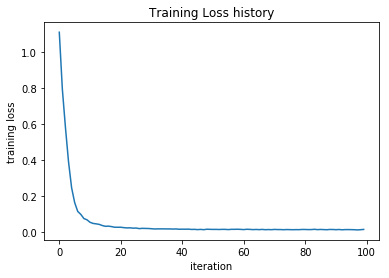

In [57]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Classify CIFAR-10

Do classification on the CIFAR-10 dataset.

In [58]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Train data shape: ', (49000, 3072))
('Train labels shape: ', (49000,))
('Validation data shape: ', (1000, 3072))
('Validation labels shape: ', (1000,))
('Test data shape: ', (1000, 3072))
('Test labels shape: ', (1000,))


### Running SGD

If your implementation is correct, you should see a validation accuracy of around 28-29%.

In [59]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Save this net as the variable subopt_net for later comparison.
subopt_net = net

iteration 0 / 1000: loss 2.30275751861
iteration 100 / 1000: loss 2.30212015921
iteration 200 / 1000: loss 2.29561360074
iteration 300 / 1000: loss 2.25182590432
iteration 400 / 1000: loss 2.18899523505
iteration 500 / 1000: loss 2.11625277919
iteration 600 / 1000: loss 2.0646708277
iteration 700 / 1000: loss 1.99016886231
iteration 800 / 1000: loss 2.00282764012
iteration 900 / 1000: loss 1.94651768179
('Validation accuracy: ', 0.283)


## Questions:

The training accuracy isn't great.  

(1) What are some of the reasons why this is the case?  Take the following cell to do some analyses and then report your answers in the cell following the one below.

(2) How should you fix the problems you identified in (1)?


In [60]:
stats['train_acc_history']

[0.095, 0.15, 0.25, 0.25, 0.315]

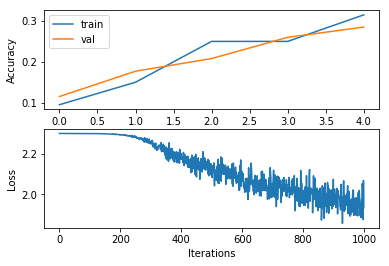

In [78]:
# ================================================================ #
# YOUR CODE HERE:
#   Do some debugging to gain some insight into why the optimization
#   isn't great.
# ================================================================ #

# Plot the loss function and train / validation accuracies
plt.subplot(2,1,1)

plt.ylabel('Accuracy')
plt.plot(stats['train_acc_history'],label='train')
plt.xlabel('Iterations')
plt.plot(stats['val_acc_history'],label='val')
plt.legend()
plt.subplot(2,1,2)
plt.plot(stats['loss_history'])
plt.xlabel('Iterations')
plt.ylabel('Loss')

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

## Answers:

(1) the loss is decreasing linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, which means that the model we are using is of low capacity. 


(2) Change the learning rate (increase) and increase the size of the neural network( number of hidden layers)

## Optimize the neural network

Use the following part of the Jupyter notebook to optimize your hyperparameters on the validation set.  Store your nets as best_net.

In [87]:
best_net = None # store the best model into this 

# ================================================================ #
# YOUR CODE HERE:
#   Optimize over your hyperparameters to arrive at the best neural
#   network.  You should be able to get over 50% validation accuracy.
#   For this part of the notebook, we will give credit based on the
#   accuracy you get.  Your score on this question will be multiplied by:
#      min(floor((X - 28%)) / %22, 1) 
#   where if you get 50% or higher validation accuracy, you get full
#   points.
#
#   Note, you need to use the same network structure (keep hidden_size = 50)!
# ================================================================ #
hidden_size = 50
lr = 1e-3
regularization_strengths = [0.85, 0.89]
best_net = None # store the best model into this 
best_stats = None
results = {}
best_val = -1

for reg in regularization_strengths:
    np.random.seed(0)
    print "hidden size: %d, lr: %.4f, reg: %.2f" %(hidden_size, lr, reg)
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=3000, batch_size=200,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
    print 'train accuracy: %.4f' %stats['train_acc_history'][-1]
    print 'validation accuracy: %.4f' %stats['val_acc_history'][-1]

      # check if validation accuracy is best or not
    if best_val < stats['val_acc_history'][-1]:
        best_val = stats['val_acc_history'][-1]
        best_net = net
        best_stats = stats
         
print 'best validation accuracy achieved during cross-validation: %f' % best_val

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
best_net = net

hidden size: 50, lr: 0.0010, reg: 0.85
train accuracy: 0.5400
validation accuracy: 0.5040
hidden size: 50, lr: 0.0010, reg: 0.89
train accuracy: 0.5750
validation accuracy: 0.5120
best validation accuracy achieved during cross-validation: 0.512000


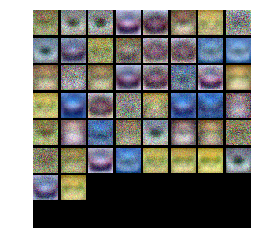

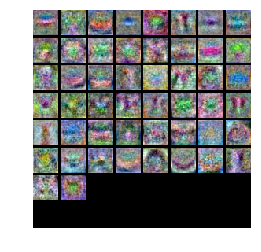

In [88]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.T.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(subopt_net)
show_net_weights(best_net)

## Question:

(1) What differences do you see in the weights between the suboptimal net and the best net you arrived at?

## Answer:

(1) In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized. In suboptimal net, we are not able to visualize the structure which is clearer with the best net.  

## Evaluate on test set 

In [89]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

('Test accuracy: ', 0.513)
